```{index} single: Pyomo; sets
```
```{index} single: Pyomo; decorators
```
```{index} single: solver; cbc
```
```{index} single: solver; highs
```
```{index} single: application; production planning
```
```{index} single: application; demand forecasts
```
```{index} pandas dataframe
```

# BIM production using demand forecasts

In [1]:
# install pyomo and select solver
import sys

SOLVER = "cbc"

if "google.colab" in sys.modules:
    !pip install highspy >/dev/null
    SOLVER = "appsi_highs"

## The problem: Optimal material acquisition and production planning using demand forecasts

This example is a continuation of the BIM chip production problem illustrated [here](bim.ipynb). Recall hat BIM produces logic and memory chips using copper, silicon, germanium, and plastic and that each chip requires the following quantities of raw materials:

| chip   | copper | silicon | germanium | plastic |
|:-------|-------:|--------:|----------:|--------:|
|logic   |    0.4 |       1 |         - |       1 |
|memory  |    0.2 |       - |         1 |       1 |

BIM needs to carefully manage the acquisition and inventory of these raw materials based on the forecasted demand for the chips. Data analysis led to the following prediction of monthly demands:

| chip   | Jan | Feb | Mar | Apr | May | Jun | Jul | Aug | Sep | Oct | Nov | Dec |
|:-------|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
|logic   |  88 | 125 | 260 | 217 | 238 | 286 | 248 | 238 | 265 | 293 | 259 | 244 |
|memory  |  47 |  62 |  81 |  65 |  95 | 118 |  86 |  89 |  82 |  82 |  84 | 66  |

At the beginning of the year, BIM has the following stock:

|copper|silicon|germanium|plastic|
|-----:|------:|--------:|------:|
|   480|  1000 |     1500|  1750 |

The company would like to have at least the following stock at the end of the year:

|copper|silicon|germanium|plastic|
|-----:|------:|--------:|------:|
|   200|   500 |      500|  1000 |

Each raw material can be acquired at each month, but the unit prices vary as follows:

| product  | Jan | Feb | Mar | Apr | May | Jun | Jul | Aug | Sep | Oct | Nov | Dec |
|:---------|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
|copper    |   1 |   1 |   1 |   2 |   2 |   3 |   3 |   2 |   2 |   1 |   1 |   2 |
|silicon   |   4 |   3 |   3 |   3 |   5 |   5 |   6 |   5 |   4 |   3 |   3 |   5 |
|germanium |   5 |   5 |   5 |   3 |   3 |   3 |   3 |   2 |   3 |   4 |   5 |   6 |
|plastic   | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 |

The inventory is limited by a capacity of a total of 9000 units per month, regardless of the type of material of products in stock. The holding costs of the inventory are 0.05 per unit per month regardless of the material type. Due to budget constraints, BIM cannot spend more than 5000 per month on acquisition.

BIM aims at minimizing the acquisition and holding costs of the materials while meeting the required quantities for production. The production is made to order, meaning that no inventory of chips is kept.

Let us model the material acquisition planning and solve it optimally based on the forecasted chip demand above.

Let us first import both the price and forecast chip demand as Pandas dataframes.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd

demand_data = '''chip,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
logic,88,125,260,217,238,286,248,238,265,293,259,244
memory,47,62,81,65,95,118,86,89,82,82,84,66'''
price_data = '''product,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
copper,1,1,1,2,2,3,3,2,2,1,1,2
silicon,4,3,3,3,5,5,6,5,4,3,3,5
germanium,5,5,5,3,3,3,3,2,3,4,5,6
plastic,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1'''

demand_chips = pd.read_csv(StringIO(demand_data), index_col='chip' )
display(demand_chips)

price = pd.read_csv( StringIO(price_data), index_col='product' )
price

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
chip,,,,,,,,,,,,
logic,88,125,260,217,238,286,248,238,265,293,259,244
memory,47,62,81,65,95,118,86,89,82,82,84,66


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
product,,,,,,,,,,,,
copper,1.0,1.0,1.0,2.0,2.0,3.0,3.0,2.0,2.0,1.0,1.0,2.0
silicon,4.0,3.0,3.0,3.0,5.0,5.0,6.0,5.0,4.0,3.0,3.0,5.0
germanium,5.0,5.0,5.0,3.0,3.0,3.0,3.0,2.0,3.0,4.0,5.0,6.0
plastic,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


We can also add a small dataframe with the consumptions and obtain the monthly demand for each raw material using a simple matrix multiplication.

In [3]:
use = dict()
use['logic'] = { 'silicon' : 1, 'plastic' : 1, 'copper' : 4 }
use['memory'] = { 'germanium' : 1, 'plastic' : 1, 'copper' : 2 }
use = pd.DataFrame.from_dict(use).fillna(0).astype(int)
display(use)

demand = use.dot(demand_chips)
demand

,logic,memory
silicon,1,0
plastic,1,1
copper,4,2
germanium,0,1


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,88,125,260,217,238,286,248,238,265,293,259,244
plastic,135,187,341,282,333,404,334,327,347,375,343,310
copper,446,624,1202,998,1142,1380,1164,1130,1224,1336,1204,1108
germanium,47,62,81,65,95,118,86,89,82,82,84,66


## The optimization model

Define the set of raw material $P=\{\text{copper},\text{silicon},\text{germanium},\text{plastic}\}$ and $T$ the set of the $12$ months of the year. Let

- $x_{pt} \geq 0$ be the variable describing the amount of raw material $p \in P$ acquired in month $t \in T$;

- $s_{pt} \geq 0$ be the variable describing the amount of raw material $p \in P$ left in stock at the end of month $t \in T$. Note that these values are uniquely determined by the $x$ variables, but we keep these additional variables to ease the modeling. 

The total cost is the objective function of our optimal acquisition and production problem. If $\pi_{pt}$ is the unit price of product $p \in P$ in month $t \in T$ and $h_{pt}$ the unit holding costs (which happen to be constant) we can express the total cost as:

$$
    \sum_{p\in P}\sum_{t \in T}\pi_{pt}x_{pt} + \sum_{p\in P}\sum_{t \in T} h_{pt} s_{pt}.
$$

Let us now focus on the constraints. If $\beta \geq 0$ denotes the monthly acquisition budget, the budget constraint can be expressed as:

$$
    \sum_{p\in P} \pi_{pt}x_{pt} \leq \beta \quad \forall t \in T.
$$

Further, we constrain the inventory to be always the storage capacity $\ell \geq 0$ using:

$$
    \sum_{p\in P} s_{pt} \leq \ell \quad \forall t \in T.
$$

Next, we add another constraint to fix the value of the variables $s_{pt}$ by balancing the acquired amounts with the previous inventory and the demand $\delta_{pt}$ which for each month is implied by the total demand for the chips of both types. Note that $t-1$ is defined as the initial stock when $t$ is the first period, that is \texttt{January}. This can be obtained with additional variables $s$ made equal to those values or with a rule that specializes, as in the code below.  

$$
    x_{pt} + s_{p,t-1} = \delta_{pt} + s_{pt} \quad \forall p \in P, t \in T.
$$

Finally, we capture the required minimum inventory levels in December with the constraint.

$$
    s_{p \textrm{Dec}} \geq \Omega_p \quad \forall p \in P,
$$

where $(\Omega_p)_{p \in P}$ is the vector with the desired end inventories.

Here is the Pyomo implementation of this LP.

In [4]:
import pyomo.environ as pyo

def ShowTableOfPyomoVariables( X, I, J ):
    return pd.DataFrame.from_records( [ [ pyo.value( X[i,j] ) for j in J ] for i in I ], index=I, columns=J ).round(decimals = 2)

def BIMProductAcquisitionAndInventory( demand, acquisition_price, existing, desired, stock_limit, month_budget ):
    m = pyo.ConcreteModel( 'BIM product acquisition and inventory' )
    
    periods  = demand.columns
    products = demand.index 
    first    = periods[0] 
    prev     = { j : i for i,j in zip(periods,periods[1:]) }
    last     = periods[-1]
    
    m.T = pyo.Set( initialize=periods )
    m.P = pyo.Set( initialize=products )
    m.PT = m.P * m.T # to avoid internal set bloat
    
    m.x = pyo.Var( m.PT, within=pyo.NonNegativeReals )
    m.s = pyo.Var( m.PT, within=pyo.NonNegativeReals )
    
    @m.Param( m.PT )
    def pi(m,p,t):
        return acquisition_price.loc[p][t]
    
    @m.Param( m.PT )
    def h(m,p,t): 
        return .05 # the holding cost
    
    @m.Param( m.PT )
    def delta(m,p,t):
        return demand.loc[p,t]
    
    @m.Expression()
    def acquisition_cost( m ):
        return pyo.quicksum( m.pi[p,t] * m.x[p,t] for p in m.P for t in m.T )
    
    @m.Expression()
    def inventory_cost( m ):
        return pyo.quicksum( m.h[p,t] * m.s[p,t] for p in m.P for t in m.T )
    
    @m.Objective( sense=pyo.minimize )
    def total_cost( m ):
        return m.acquisition_cost + m.inventory_cost
    
    @m.Constraint( m.PT )
    def balance( m, p, t ):
        if t == first:
            return existing[p] + m.x[p,t] == m.delta[p,t] + m.s[p,t]
        else:
            return m.x[p,t] + m.s[p,prev[t]] == m.delta[p,t] + m.s[p,t]
        
    @m.Constraint( m.P )
    def finish( m, p ):
        return m.s[p,last] >= desired[p]
    
    @m.Constraint( m.T )
    def inventory( m, t ):
        return pyo.quicksum( m.s[p,t] for p in m.P ) <= stock_limit
    
    @m.Constraint( m.T )
    def budget( m, t ):
        return pyo.quicksum( m.pi[p,t]*m.x[p,t] for p in m.P ) <= month_budget
    
    return m

We now can create an instance of the model using the provided data and solve it.


The optimal amount of raw materials to acquire in each month is:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,0.0,0.0,0.0,965.0,0.0,0.0,0.0,0.0,0.0,1078.1,217.9,0.0
plastic,0.0,0.0,0.0,0.0,0.0,0.0,266.0,327.0,347.0,375.0,343.0,1310.0
copper,0.0,0.0,3548.0,0.0,0.0,0.0,0.0,0.0,962.0,1336.0,4312.0,0.0
germanium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



The corresponding optimal stock levels in each months are:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,912.0,787.0,527.0,1275.0,1037.0,751.0,503.0,265.0,0.0,785.1,744.0,500.0
plastic,1615.0,1428.0,1087.0,805.0,472.0,68.0,0.0,0.0,0.0,0.0,0.0,1000.0
copper,4354.0,3730.0,6076.0,5078.0,3936.0,2556.0,1392.0,262.0,0.0,0.0,3108.0,2000.0
germanium,1453.0,1391.0,1310.0,1245.0,1150.0,1032.0,946.0,857.0,775.0,693.0,609.0,543.0



The stock levels can be visualized as follows


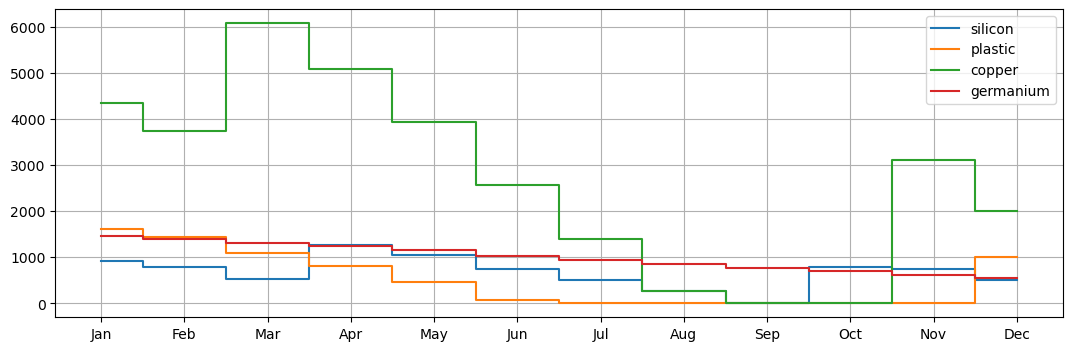

In [5]:
budget = 5000
m = BIMProductAcquisitionAndInventory( demand, price, 
           {'silicon' : 1000, 'germanium': 1500, 'plastic': 1750, 'copper' : 4800 }, 
           {'silicon' :  500, 'germanium':  500, 'plastic': 1000, 'copper' : 2000 },
           9000, budget )

pyo.SolverFactory(SOLVER).solve(m)

print('\nThe optimal amount of raw materials to acquire in each month is:')
display(ShowTableOfPyomoVariables( m.x, m.P, m.T ))
print('\nThe corresponding optimal stock levels in each months are:')
stock = ShowTableOfPyomoVariables( m.s, m.P, m.T )
display(stock)
print('\nThe stock levels can be visualized as follows')
stock.T.plot(drawstyle='steps-mid',grid=True, figsize=(13,4))
plt.xticks(np.arange(len(stock.columns)),stock.columns)
plt.show()

Here is a different solution corresponding to the situation where the budget is much lower, namely 2000.


The optimal amount of raw materials to acquire in each month is:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,444.67,559.0,0.0,666.67,0.0,400.0,65.05,0.00,125.62,0.0,0.0,0.0
plastic,0.00,0.0,0.0,0.00,0.0,0.0,266.00,327.00,1065.00,0.0,0.0,1310.0
copper,221.33,323.0,2000.0,0.00,1000.0,0.0,0.00,983.65,695.52,2000.0,2000.0,934.5
germanium,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0



The corresponding optimal stock levels in each months are:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,1356.67,1790.67,1530.67,1980.33,1742.33,1856.33,1673.38,1435.38,1296.0,1003.0,744.0,500.0
plastic,1615.00,1428.00,1087.00,805.00,472.00,68.00,0.00,0.00,718.0,343.0,0.0,1000.0
copper,4575.33,4274.33,5072.33,4074.33,3932.33,2552.33,1388.33,1241.98,713.5,1377.5,2173.5,2000.0
germanium,1453.00,1391.00,1310.00,1245.00,1150.00,1032.00,946.00,857.00,775.0,693.0,609.0,543.0



The stock levels can be visualized as follows


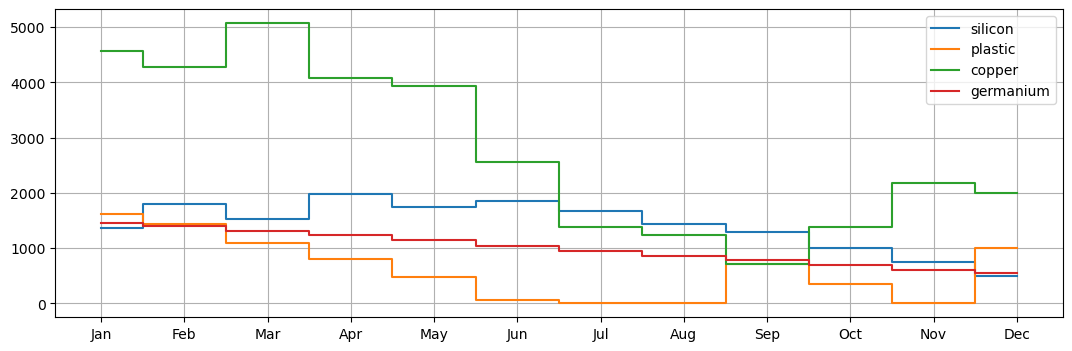

In [6]:
budget = 2000
m = BIMProductAcquisitionAndInventory( demand, price, 
           {'silicon' : 1000, 'germanium': 1500, 'plastic': 1750, 'copper' : 4800 }, 
           {'silicon' :  500, 'germanium':  500, 'plastic': 1000, 'copper' : 2000 },
           9000, budget )

pyo.SolverFactory(SOLVER).solve(m)

print('\nThe optimal amount of raw materials to acquire in each month is:')
display(ShowTableOfPyomoVariables( m.x, m.P, m.T ))
print('\nThe corresponding optimal stock levels in each months are:')
stock = ShowTableOfPyomoVariables( m.s, m.P, m.T )
display(stock)
print('\nThe stock levels can be visualized as follows')
stock.T.plot(drawstyle='steps-mid',grid=True, figsize=(13,4))
plt.xticks(np.arange(len(stock.columns)),stock.columns)
plt.show()

Looking at the two optimal solutions corresponding to different budgets, we can note that:
* The budget is not limitative;
* With the initial budget of 5000 the solution remains integer;
* Lowering the budget to 2000 forces acquiring fractional quantities;
* Lower values of the budget end up making the problem infeasible.

### A more parsimonious model

We can create a more parsimonious model with fewer variabels by getting rid of the auxiliary variables $s_{pt}$. Here is the corresponding implementation in Pyomo:

In [7]:
def BIMProductAcquisitionAndInventory_v2( demand, acquisition_price, existing, desired, stock_limit, month_budget ):
    
    m = pyo.ConcreteModel( 'Product acquisition and inventory' )
    
    periods  = demand.columns
    products = demand.index 
    first    = periods[0] 
    prev     = { j : i for i,j in zip(periods,periods[1:]) }
    last     = periods[-1]
    
    m.T = pyo.Set( initialize=periods )
    m.P = pyo.Set( initialize=products )
    m.PT = m.P * m.T # to avoid internal set bloat
    
    m.x = pyo.Var( m.PT, within=pyo.NonNegativeReals )
    
    @m.Param( m.PT )
    def pi(m,p,t):
        return acquisition_price.loc[p][t]
    
    @m.Param( m.PT )
    def h(m,p,t): 
        return .05 # the holding cost
    
    @m.Param( m.PT )
    def delta(m,p,t):
        return demand.loc[p,t]
    
    @m.Expression( m.PT )
    def s( m, p, t ):
        if t == first:
            return existing[p] + m.x[p,t] - m.delta[p,t]
        else:
            return m.x[p,t] + m.s[p,prev[t]] - m.delta[p,t]
        
    @m.Constraint( m.PT )
    def non_negative_stock( m, p, t ):
        return m.s[p,t] >= 0
    
    @m.Expression()
    def acquisition_cost( m ):
        return pyo.quicksum( m.pi[p,t] * m.x[p,t] for p in m.P for t in m.T )
    
    @m.Expression()
    def inventory_cost( m ):
        return pyo.quicksum( m.h[p,t] * m.s[p,t] for p in m.P for t in m.T )
    
    @m.Objective( sense=pyo.minimize )
    def total_cost( m ):
        return m.acquisition_cost + m.inventory_cost
            
    @m.Constraint( m.P )
    def finish( m, p ):
        return m.s[p,last] >= desired[p]
    
    @m.Constraint( m.T )
    def inventory( m, t ):
        return pyo.quicksum( m.s[p,t] for p in m.P ) <= stock_limit
    
    @m.Constraint( m.T )
    def budget( m, t ):
        return pyo.quicksum( m.pi[p,t]*m.x[p,t] for p in m.P ) <= month_budget
    
    return m


The optimal amount of raw materials to acquire in each month is:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,444.67,559.0,0.0,666.67,0.0,400.0,65.05,0.00,125.62,0.0,0.0,0.0
plastic,0.00,0.0,0.0,0.00,0.0,0.0,266.00,327.00,1065.00,0.0,0.0,1310.0
copper,221.33,323.0,2000.0,0.00,1000.0,0.0,0.00,983.65,695.52,2000.0,2000.0,934.5
germanium,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0



The corresponding optimal stock levels in each months are:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,1356.67,1790.67,1530.67,1980.33,1742.33,1856.33,1673.38,1435.38,1296.0,1003.0,744.0,500.0
plastic,1615.00,1428.00,1087.00,805.00,472.00,68.00,0.00,0.00,718.0,343.0,0.0,1000.0
copper,4575.33,4274.33,5072.33,4074.33,3932.33,2552.33,1388.33,1241.98,713.5,1377.5,2173.5,2000.0
germanium,1453.00,1391.00,1310.00,1245.00,1150.00,1032.00,946.00,857.00,775.0,693.0,609.0,543.0



The stock levels can be visualized as follows


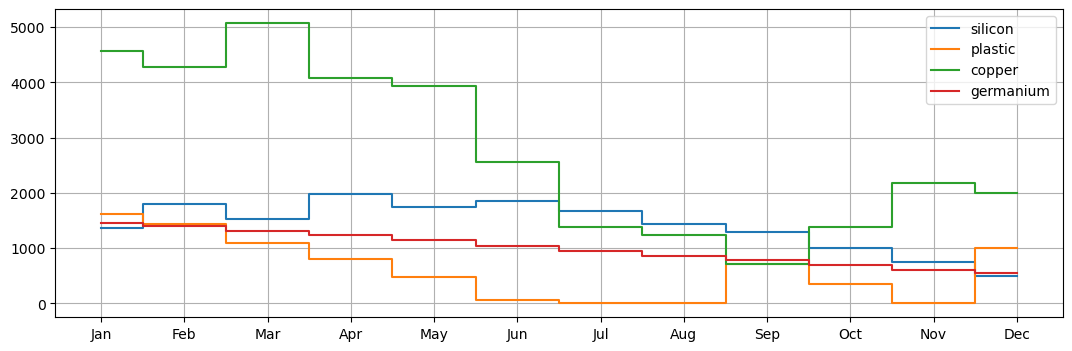

In [8]:
m = BIMProductAcquisitionAndInventory_v2( demand, price, 
           {'silicon' : 1000, 'germanium': 1500, 'plastic': 1750, 'copper' : 4800 }, 
           {'silicon' :  500, 'germanium':  500, 'plastic': 1000, 'copper' : 2000 },
           9000, 2000 )

pyo.SolverFactory(SOLVER).solve(m)

print('\nThe optimal amount of raw materials to acquire in each month is:')
display(ShowTableOfPyomoVariables( m.x, m.P, m.T ))
print('\nThe corresponding optimal stock levels in each months are:')
stock = ShowTableOfPyomoVariables( m.s, m.P, m.T )
display(stock)
print('\nThe stock levels can be visualized as follows')
stock.T.plot(drawstyle='steps-mid',grid=True, figsize=(13,4))
plt.xticks(np.arange(len(stock.columns)),stock.columns)
plt.show()